In [1]:
# actual test
import cv2 as cv 
import numpy as np
import matplotlib.pyplot as plt
import mss.tools
import time
import uuid
import keyboard
import math
import pyautogui
import time
import mss.tools
import uuid
import keyboard
from pynput import mouse

In [ ]:


 
def on_keyboard_event(event):
    print(f"Keyboard: Key {event.name} {'pressed' if event.event_type == 'down' else 'released'}")
 
def on_mouse_event(x, y, button, pressed):
    if pressed:
        print(f"Mouse: Button {button} pressed at ({x}, {y})")
    else:
        print(f"Mouse: Button {button} released at ({x}, {y})")
 
keyboard.hook(on_keyboard_event)
#print(f"{button} is pressed") 
with mouse.Listener(on_click=on_mouse_event) as listener:
    print("Press keys or click the mouse (Press 'Esc' to exit)")
    keyboard.wait('esc')  # Wait for the 'esc' key to exit the program
 
    listener.stop()  # Stop the mouse listener
    keyboard.unhook_all()  # Unhook the keyboard eventsqqa


In [2]:
def screenshot(folder):
    with mss.mss() as sct:
        monitor_info = sct.monitors[0]
        top_margin = (monitor_info["height"] // 4) + 50
        monitor = {"top": monitor_info["top"] + top_margin, "left": monitor_info["left"] + 55, "width": monitor_info["width"] - 120, "height": (monitor_info["height"] * 2 // 3)-450}
        output = f"DLIngrid/{folder}/{str(uuid.uuid4())}.png".format(**monitor)
        sct_img = sct.grab(monitor)
        mss.tools.to_png(sct_img.rgb, sct_img.size, output=output)
    return output

In [ ]:
def on_keyboard_event(event):
    #print(f"Keyboard: Key {event.name} {'pressed' if event.event_type == 'down' else 'released'}")
    return screenshot(event.name)
def on_mouse_event(x, y, button, pressed):
    return screenshot("forward")
time.sleep(5)
keyboard.hook(on_keyboard_event)


with mouse.Listener(on_click=on_mouse_event) as listener:
    print("Press keys or click the mouse (Press 'Esc' to exit)")
    keyboard.wait('space')  # Wait for the 'esc' key to exit the program
    
    listener.stop()  # Stop the mouse listener
    keyboard.unhook_all()  # Unhook the keyboard eventsqqa

In [2]:
import fastbook
fastbook.setup_book()

In [3]:
from fastbook import *

In [4]:
data = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    # the line of code below is just using Regular Expressions to link a file to a label
    # the label, the breed of the pet, is in the filename, that's why we need a regex to extract it as the label
    get_y=parent_label,
    # now let's also add some awesome augmentation (presizing) into the mix as well
    #item_tfms=Resize(460),
    batch_tfms=aug_transforms(size=224, min_scale=0.75))

In [5]:
dls = data.dataloaders("./croppeddataingrid")

c:\Users\ingri\anaconda3\envs\mss\Lib\site-packages\fastai\torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)


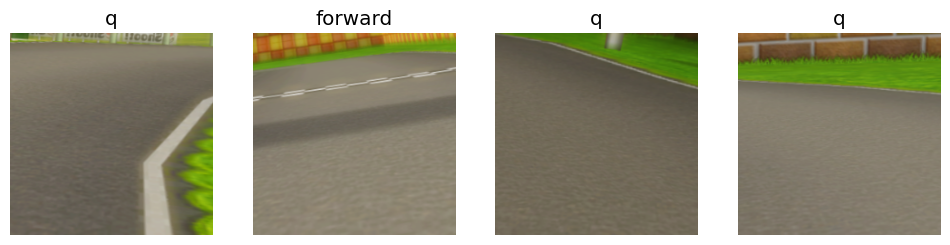

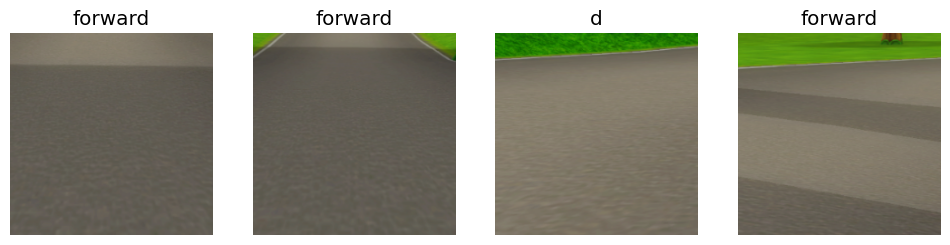

In [6]:
dls.train.show_batch(max_n=4, nrows=1)
dls.valid.show_batch(max_n=4, nrows=1)

In [7]:
resnet50_model = vision_learner(dls, resnet50, metrics=error_rate)
resnet50_model.fine_tune(1)

epoch,train_loss,valid_loss,error_rate,time
0,1.611471,0.769876,0.335484,01:49


epoch,train_loss,valid_loss,error_rate,time
0,1.184912,0.726385,0.309677,04:48


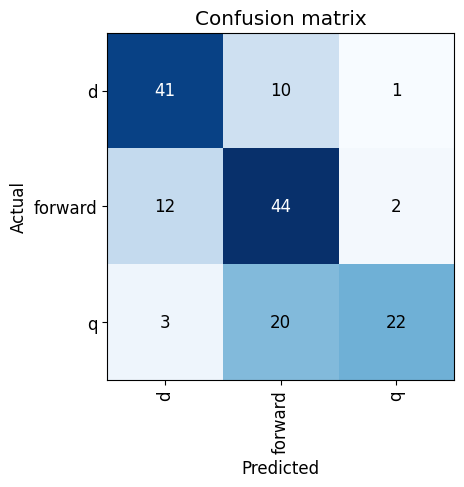

In [8]:
interp = ClassificationInterpretation.from_learner(resnet50_model)
interp.plot_confusion_matrix()

In [9]:
from keras.applications import ResNet50
model = ResNet50(input_shape=(448, 448, 3), weights='imagenet', include_top=False)

In [10]:
for layer in model.layers[:-1]:
  layer.trainable = False

In [11]:
from keras.models import Sequential
from keras.layers import GlobalAveragePooling2D, Dense, Activation
custom_model = Sequential()
custom_model.add(model)
custom_model.add(GlobalAveragePooling2D())
custom_model.add(Dense(3)) # 4 is the number of classes in your dataset
custom_model.add(Activation('softmax'))

In [12]:
import splitfolders


In [23]:
input_folder = './DLIngrid'
output_folder = './splitcroppeddataingrid'
 
#split the images into 80% training and 20% testing sets
splitfolders.ratio(input_folder, output_folder, seed=96, ratio=(0.8, 0.2))

Copying files: 1353 files [00:09, 143.09 files/s]


In [24]:
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./255) # rescale the pixel values to [0, 1] range
test_datagen = ImageDataGenerator(rescale=1./255) # same for test set


In [25]:
train_generator = train_datagen.flow_from_directory(
    directory='./datasetsingrid/train', # the path to the training set
    target_size=(448, 448), # the desired image size
    batch_size=32, # the number of images per batch
    class_mode='categorical', # the type of labels
    shuffle=True # whether to shuffle the images
)

test_generator = test_datagen.flow_from_directory(
    directory='./datasetsingrid/val', # the path to the test set
    target_size=(448, 448), # the same image size as training
    batch_size=32, # the same batch size as training
    class_mode='categorical', # the same label type as training
    shuffle=False # whether to shuffle the images
)


Found 1393 images belonging to 3 classes.


Found 350 images belonging to 3 classes.


In [26]:
custom_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
#custom_model.fit(x_train, y_train, batch_size=32, epochs=10, validation_data=(x_val, y_val))


In [28]:
custom_model.fit(
    train_generator, # the train generator
    steps_per_epoch=len(train_generator), # the number of batches per epoch
    validation_data=test_generator, # the test generator
    validation_steps=len(test_generator), # the number of batches for validation
    epochs=10 # the number of epochs
)

Epoch 1/10
44/44 [==============================] - ETA: 0s - loss: 0.9877 - accuracy: 0.5377